<a href="https://colab.research.google.com/github/Shujaat123/SADIA_KFUPM_JRCAI_Workshop/blob/main/2)_Model_agnostic_%E2%80%94_permutation_importance_%2B_PDP_ICE_%2B_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COE 691 – Special Topics in Computer Engineering I (Explainable Artificial Intelligence)

## Demo 1: Model-agnostic: permutation importance, PDP/ICE (sklearn), and LIME (tabular)

This notebook demonstrates model-agnostic explainability using Partial Dependence (PDP) and Individual Conditional Expectation (ICE) for the feature MedInc (median income) in a Random Forest classifier built on the California Housing dataset (binarized target: above/below median value).

Goal: Understand how changing MedInc affects the model’s predicted probability that a district is high-valued.

## About `fetch_california_housing` (scikit-learn)

**What it is**
A tabular regression dataset built from the **1990 U.S. Census** for California block groups. Each row is a small geographic area (“district”/block group). The task is to predict **median house value**.

**Size & schema**

* **Samples:** 20,640
* **Features (8):**

  * `MedInc` — *median income* in **tens of thousands USD** (e.g., 3.5 ≈ $35k)
  * `HouseAge` — median house age (years)
  * `AveRooms` — average rooms per household
  * `AveBedrms` — average bedrooms per household
  * `Population` — block group population
  * `AveOccup` — average household size (occupancy)
  * `Latitude`, `Longitude` — geographic coordinates
* **Target:** `MedHouseVal` — median house value in **hundreds of thousands USD** (e.g., 2.1 ≈ $210k)

**Quirks / caveats**

* **Ceiling effect:** Values above $500k were **capped** in 1990 → many targets near `5.0`.
* **Spatial structure:** Strong **geo** effects; models benefit from interactions with latitude/longitude or regional features.
* **Heteroskedasticity:** Variance of errors changes across income/regions—consider robust metrics/plots.
* **No missing values;** features on very different scales → standardize if using linear models.

**Typical preprocessing tips**

* Consider log transform of target: `y_log = np.log1p(y)` to reduce skew.
* Add simple interactions (e.g., `MedInc × Latitude`) or engineered region buckets.
* Always evaluate with **cross-validation**; report **MAE/RMSE** (and optionally on the original $ scale).

**Quick start (pandas frame & peek)**

```python
from sklearn.datasets import fetch_california_housing
import pandas as pd

ds = fetch_california_housing(as_frame=True)
X, y = ds.data, ds.target
print(X.shape, y.shape)          # (20640, 8) (20640,)
print(X.head())
print("Target name:", ds.target_names)  # ['MedHouseVal']
```

**Baseline model**

```python
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=0)
rf = RandomForestRegressor(n_estimators=300, random_state=0).fit(Xtr, ytr)
pred = rf.predict(Xte)
mae = mean_absolute_error(yte, pred)
rmse = mean_squared_error(yte, pred, squared=False)
print(f"MAE={mae:.3f} (×$100k), RMSE={rmse:.3f} (×$100k)")
```

**Why it’s great for XAI demos**

* Clean, compact, **interpretable feature names** (income, rooms, location).
* Shows clear **monotonic** trends (e.g., `MedInc`) and **interactions** (with geo).
* Works well with **PFI, PDP/ICE, LIME/SHAP**, and local-vs-global explanation comparisons.


In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1ac3849e651ad136afa00ebb0d85f25dc87d9b2521042b3edc925205e58a9ed0
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


AUC: 0.956413144704817

Permutation importance (top 8):
MedInc                     +0.1779
Latitude                   +0.1738
Longitude                  +0.1465
AveOccup                   +0.0672
AveRooms                   +0.0209
HouseAge                   +0.0121
AveBedrms                  +0.0031
Population                 +0.0023


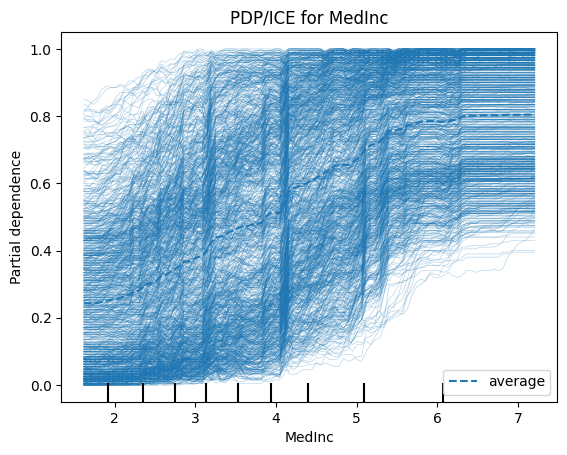

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



LIME explanation for test instance 0:
Longitude <= -121.80            +0.186
2.56 < MedInc <= 3.54           -0.113
AveOccup <= 2.44                +0.102
34.26 < Latitude <= 37.71       -0.060
AveBedrms > 1.10                -0.015
AveRooms <= 4.46                +0.009
18.00 < HouseAge <= 29.00       +0.004
Population <= 785.00            -0.003


In [3]:
# Model-agnostic: permutation importance, PDP/ICE (sklearn), and LIME (tabular)
# -----------------------------------------------------------------------------
# Goal:
#   1) Train a black-box model (Random Forest) on a simple binary target.
#   2) Compute GLOBAL importance with Permutation Importance (PFI).
#   3) Visualize FEATURE EFFECTS with PDP/ICE for one key feature.
#   4) Produce a LOCAL explanation for one instance with LIME.

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# --- 0) Data setup ------------------------------------------------------------
# We convert the regression target (MedHouseVal) into a binary label by thresholding
# at the median to create a balanced classification task.
data = fetch_california_housing(as_frame=True)
X = data.frame.drop(columns=["MedHouseVal"])
y = (data.frame["MedHouseVal"] > data.frame["MedHouseVal"].median()).astype(int)

# Stratified split to preserve class balance in train/test.
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

# --- 1) Train a black-box model ----------------------------------------------
# Random Forest stands in for a non-linear, interaction-capable model.
rf = RandomForestClassifier(n_estimators=200, random_state=0).fit(Xtr, ytr)

# AUC (threshold-free metric) is a good quick check for separability.
print("AUC:", roc_auc_score(yte, rf.predict_proba(Xte)[:, 1]))

# --- 2) Global Fidelity: Permutation Feature Importance ----------------------
# PFI permutes one feature at a time in the TEST set and measures the drop in performance.
# Larger mean drop => model relied more on that feature.
pi = permutation_importance(rf, Xte, yte, n_repeats=5, random_state=0)

# Rank features by mean importance and show the top-8.
idx = np.argsort(pi.importances_mean)[::-1][:8]
print("\nPermutation importance (top 8):")
for i in idx:
    print(f"{X.columns[i]:25s}  {pi.importances_mean[i]:+.4f}")

# Partial Dependence & ICE (Individual Conditional Expectation) plots
# --- 3) Effect Visualization: PDP + ICE --------------------------------------
# PDP shows average (global) effect of a feature; ICE shows per-sample curves (heterogeneity).
# Note: For correlated features, PDP can show unrealistic regions—interpret qualitatively.
feat = X.columns[idx[0]]  # pick the highest PFI feature
PartialDependenceDisplay.from_estimator(
    rf, Xte, [feat], kind="both"   # 'both' = PDP + ICE together for a single feature ['average', 'both', 'individual']
)
plt.title(f"PDP/ICE for {feat}")
plt.show()

# --- 4) Local Explanation: LIME ----------------------------------------------
# LIME fits a simple, local surrogate around one instance to approximate the RF decision.
# If import fails, install into the *current* kernel with:
#   import sys, subprocess; subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "lime"])
from lime.lime_tabular import LimeTabularExplainer

# Build the explainer on TRAIN data (feature ranges, discretization bins).
explainer = LimeTabularExplainer(
    Xtr.values,
    feature_names=X.columns,
    class_names=["low", "high"],   # interpret class 1 as 'high' median value
    discretize_continuous=True,
    random_state=0
)

# Explain the FIRST test instance; LIME will sample neighbors and fit a local linear model.
i = 0
exp = explainer.explain_instance(
    Xte.iloc[i].values,
    rf.predict_proba,      # black-box function to query
    num_features=8         # top-k local contributors to display
)

print("\nLIME explanation for test instance 0:")
for k, v in exp.as_list():
    # Positive weight => pushes toward the positive class ('high'); negative => toward 'low'
    print(f"{k:30s}  {v:+.3f}")


## Reading the outputs

### PFI table: larger mean drop ⇒ more globally important. Compare with domain intuition.

### PDP/ICE: PDP = average effect; ICE = per-sample lines (check interactions/heterogeneity).

### LIME list: per-instance contributors (local to that point). Signs show direction; magnitudes show local influence.

## What the Plot Shows (PDP/ICE): interpretation of results

<!-- ![image.png](attachment:image.png) -->

- x-axis (MedInc): median household income.

- y-axis (partial dependence): model-predicted probability of the high-value class.

### Elements

- Blue lines (ICE): One line per test sample. Each line shows how that specific sample’s prediction changes as MedInc varies while other features are held fixed.

- Orange dashed line (PDP): The average of all ICE curves. Summarizes the mean effect of MedInc.

### Key Interpretation

- The PDP increases left → right: higher MedInc ⇒ higher probability of high-value housing.

- The relationship is roughly monotonic, indicating the model learned a clear positive association.

- Variability (spread) among blue lines indicates interactions with other features; tighter bundles imply a more uniform effect.

### How to Read the Curves

- Steep PDP regions: small income changes strongly affect predictions.

- Flat PDP regions: model is relatively insensitive to income changes there.

- Wide ICE spread: strong context dependence (feature interactions).

- Narrow ICE spread: consistent effect across samples.

### Caveats & Good Practice

- Correlated features: PDP can evaluate unrealistic (“out-of-distribution”) combinations; use it as a qualitative diagnostic.

- Stability: Prefer multiple runs / bootstraps or add Permutation Feature Importance (PFI) for global sanity checks.

- Local vs global: PDP is global; for a specific district, use local methods (e.g., LIME, SHAP) to justify that instance’s prediction.

## What the Local Explanation Shows (LIME): interpretation of results

```
Longitude <= -121.80            +0.186
2.56 < MedInc <= 3.54           -0.113
AveOccup <= 2.44                +0.102
34.26 < Latitude <= 37.71       -0.060
AveBedrms > 1.10                -0.015
AveRooms <= 4.46                +0.009
18.00 < HouseAge <= 29.00       +0.004
Population <= 785.00            -0.003
```

* **Target class:** `high` house value (positive class).
* **Sign of weight:** `+` pushes the prediction toward **high value**; `−` pushes toward **low value**.
* **Magnitude:** Larger absolute values ⇒ stronger **local** influence.
* **Bins:** Continuous features are discretized (e.g., `2.56 < MedInc <= 3.54`), so contributions are **piecewise** and **local**.

### Elements

* **Local surrogate:** LIME builds a simple linear model **around this one instance** by sampling nearby points.
* **Feature bins & weights:** Show which conditions in the neighborhood most affect the prediction and by how much.

### Key Interpretation

* **Longitude ≤ −121.80 (+0.186):** Being further west (closer to the coast) **raises** the local probability of high value.
* **2.56 < MedInc ≤ 3.54 (−0.113):** Mid-range median income **lowers** the probability for this instance (higher income bins typically help).
* **AveOccup ≤ 2.44 (+0.102):** Lower occupancy (less crowding) **raises** the probability.
* **34.26 < Latitude ≤ 37.71 (−0.060):** This latitude band **lowers** the prediction relative to slightly more northern areas (e.g., Bay Area).
* Remaining terms have **smaller** effects here (near-zero contributions).

### How to Read the Table

* **Order by |weight|** to see the **dominant local drivers** first.
* **Positive rows**: push the model toward **high value**;
  **Negative rows**: push toward **low value**.
* **Thresholded bins** reflect LIME’s discretization; nearby bin boundaries can flip signs.

### Caveats & Good Practice

* **Local ≠ global:** These weights describe behavior **near this instance only**.
* **Discretization sensitivity:** Different binning can change small weights.
* **Correlated features:** Directions may reflect **trade-offs** among correlated variables, not causality.
* **Stability:** Use a fixed `random_state`; repeat runs to check variability.
* **Sanity checks:** Compare with **Permutation Feature Importance** (global) or **SHAP** (local/global) for consistency.
